# Task 1.1 - Dataset Exploration

### Load training data in a dataframe

In [1]:
import gdown
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from torch.nn.utils.rnn import pack_padded_sequence

import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier

from utils import TimeSeriesDataset, collate_fn, load_data

In [2]:
data_url = "https://drive.google.com/drive/folders/1MyX__3hRiPkWHGFKqZXpOyq32KQpPDTR?usp=sharing"
gdown.download_folder(data_url, quiet=True)

['/Users/mzm/Documents/Uni/SS25/AMLS/AMLS Project Repo/data/X_train.bin',
 '/Users/mzm/Documents/Uni/SS25/AMLS/AMLS Project Repo/data/X_test.bin',
 '/Users/mzm/Documents/Uni/SS25/AMLS/AMLS Project Repo/data/y_train.csv']

In [3]:
ecg_data_path = 'data/X_train.bin'
labels_path = 'data/y_train.csv'

ecg_data = load_data(ecg_data_path, 'rb')
labels = load_data(labels_path, 'r')

In [4]:
df = pd.DataFrame({'Data': ecg_data, 'Class': labels})
df['Lengths'] = df['Data'].apply(lambda seq: len(seq))
print(f'Number of total data points: {df["Data"].count()}')
df.head()

Number of total data points: 6179


,Data,Class,Lengths
0,"[-217, -246, -294, -344, -363, -371, -377, -37...",2,9000
1,"[-446, -541, -637, -733, -819, -858, -867, -87...",2,18000
2,"[-440, -527, -614, -698, -770, -790, -796, -79...",2,9000
3,"[-1255, -1488, -1745, -2015, -2253, -2374, -23...",0,9000
4,"[156, 189, 223, 255, 291, 330, 362, 380, 390, ...",0,9000


## Plot some samples

In [5]:
# normalize data points
from sklearn.preprocessing import StandardScaler
sequences = df["Data"].to_numpy()
concat = np.concatenate(sequences).reshape(-1, 1)
scaler = StandardScaler()
scaler.fit(concat)
normalized_data = [scaler.transform(seq.reshape(-1, 1)).flatten() for seq in sequences]


def plot_sequences(data, labels, num_rows, num_cols, start_idx=0, total_sequences=10, xlim_right=1200, title="Plots"):
  
  assert 0 <= start_idx < len(data)
  assert 0 < total_sequences and total_sequences == num_rows * num_cols
  # assert start_idx + total_sequences < len(data)

  fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 + num_rows))
  sequences = data[start_idx : start_idx + total_sequences]
  classes = labels[start_idx : start_idx + total_sequences]
  sorted_idcs = np.argsort(classes)

  offset = 0
  for i in range(num_rows):
    for j in range(num_cols):
      seq = sequences[sorted_idcs[offset]]
      clss = classes[sorted_idcs[offset]]
      axs[i, j].plot(seq, label=clss)
      axs[i, j].set_xlim(0, xlim_right)
      axs[i, j].legend()
      offset += 1
  
  fig.suptitle(title, fontsize=16, y=0.95)
  plt.show()

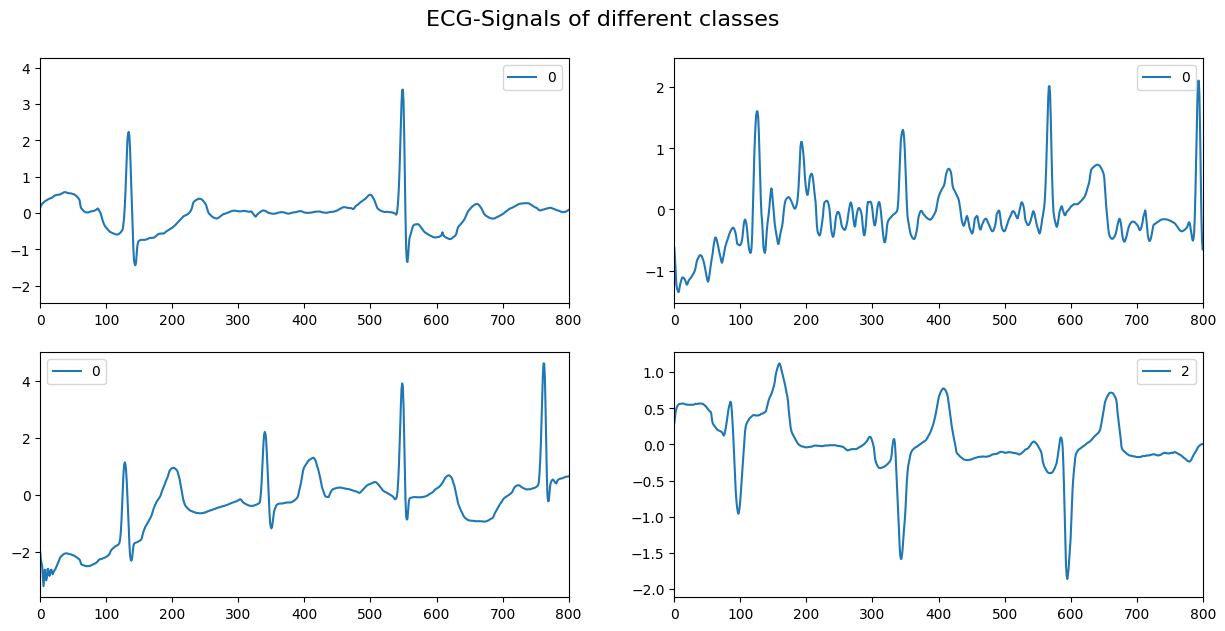

In [12]:
plot_sequences(
    normalized_data, 
    df["Class"].to_numpy(), 
    num_rows=2, num_cols=2, 
    start_idx=10, total_sequences=4, 
    xlim_right=800, title="ECG-Signals of different classes"
)

## Plot class distribution

Class 0: 3638	Class 1: 549	Class 2: 1765	Class 3: 227


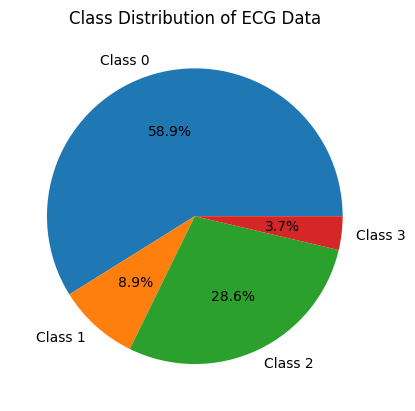

In [7]:
classes = ['Class 0', 'Class 1', 'Class 2', 'Class 3']

_df = df.groupby('Class').count()
count = _df['Data'].to_numpy()
print(f"Class 0: {count[0]}\tClass 1: {count[1]}\tClass 2: {count[2]}\tClass 3: {count[3]}")

fig, ax = plt.subplots()
ax.pie(count, labels=classes, autopct='%1.1f%%')
plt.title('Class Distribution of ECG Data')
plt.show()

### Analyze the lengths of the samples

- This information is relevant for model-selection and pre-processing of data for model


In [8]:
unique_lengths, counts = np.unique(df['Lengths'], return_counts=True)
min_val = unique_lengths.min()
max_val = unique_lengths.max()
mean_val = unique_lengths.mean()
most_frequent_length = unique_lengths[np.argmax(counts)]

# print(np.max(counts), counts[np.argmax(counts)])

print(f'Number of all different lengths: {len(unique_lengths)}\n')
print("--- Absolute Lengths ---")
print(f'Min Length: {min_val}')
print(f'Max Length: {max_val}')
print(f'Avg. Length: {mean_val:.2f}')
print(f'Most Frequent Length: {most_frequent_length} with {np.max(counts)} occurences\n')

print("--- Class dependant Lengths ---")
mins = df.groupby("Class")["Lengths"].min()
maxs = df.groupby("Class")["Lengths"].max()
avgs = df.groupby("Class")["Lengths"].mean()
print(f"Class 0  --  Min-Length: {mins[0]}  -  Max-Length: {maxs[0]}  -  Avg-Length: {int(avgs[0])}")
print(f"Class 1  --  Min-Length: {mins[1]}  -  Max-Length: {maxs[1]}  -  Avg-Length: {int(avgs[1])}")
print(f"Class 2  --  Min-Length: {mins[2]}  -  Max-Length: {maxs[2]}  -  Avg-Length: {int(avgs[2])}")
print(f"Class 3  --  Min-Length: {mins[3]}  -  Max-Length: {maxs[3]}  -  Avg-Length: {int(avgs[3])}")

Number of all different lengths: 1082

--- Absolute Lengths ---
Min Length: 2714
Max Length: 18286
Avg. Length: 8638.57
Most Frequent Length: 9000 with 4341 occurences

--- Class dependant Lengths ---
Class 0  --  Min-Length: 2714  -  Max-Length: 18286  -  Avg-Length: 9662
Class 1  --  Min-Length: 2996  -  Max-Length: 18062  -  Avg-Length: 9510
Class 2  --  Min-Length: 2738  -  Max-Length: 18188  -  Avg-Length: 10366
Class 3  --  Min-Length: 2808  -  Max-Length: 18000  -  Avg-Length: 7210


### Compute descriptive statistics

In [9]:
def get_class_statistics(df: pd.DataFrame, class_: int):

    group = df.groupby("Class")["Data"].get_group(class_)
    all_stats = np.zeros(8)

    for series in group:
        stats = pd.Series(series).describe()
        all_stats += stats

    all_stats /= group.shape[0]
    return all_stats

# df.groupby("Class")["Data"].apply()
count0, mean0, std0, min0, quant0_25, quant0_50, quant0_75, max0 = get_class_statistics(df, 0)
count1, mean1, std1, min1, quant1_25, quant1_50, quant1_75, max1 = get_class_statistics(df, 1)
count2, mean2, std2, min2, quant2_25, quant2_50, quant2_75, max2 = get_class_statistics(df, 2)
count3, mean3, std3, min3, quant3_25, quant3_50, quant3_75, max3 = get_class_statistics(df, 3)

In [10]:
print(f"-- Class 0 -- \n\nCount: {int(count0)}\nMean: {mean0:.2f}\nMin: {min0:.2f}\nMax: {max0:.2f}\n25% Quantile: {quant0_25:.2f}\n50% Quantile: {quant0_50:.2f}\n75% Quantile: {quant0_75:.2f}\n")
print(f"-- Class 1 -- \n\nCount: {int(count1)}\nMean: {mean1:.2f}\nMin: {min1:.2f}\nMax: {max1:.2f}\n25% Quantile: {quant1_25:.2f}\n50% Quantile: {quant1_50:.2f}\n75% Quantile: {quant1_75:.2f}\n")
print(f"-- Class 2 -- \n\nCount: {int(count2)}\nMean: {mean2:.2f}\nMin: {min2:.2f}\nMax: {max2:.2f}\n25% Quantile: {quant2_25:.2f}\n50% Quantile: {quant2_50:.2f}\n75% Quantile: {quant2_75:.2f}\n")
print(f"-- Class 3 -- \n\nCount: {int(count3)}\nMean: {mean3:.2f}\nMin: {min3:.2f}\nMax: {max3:.2f}\n25% Quantile: {quant3_25:.2f}\n50% Quantile: {quant3_50:.2f}\n75% Quantile: {quant3_75:.2f}")

-- Class 0 -- 

Count: 9662
Mean: 7.58
Min: -1069.66
Max: 1289.28
25% Quantile: -69.80
50% Quantile: -9.94
75% Quantile: 64.01

-- Class 1 -- 

Count: 9510
Mean: 8.91
Min: -913.85
Max: 1098.64
25% Quantile: -63.69
50% Quantile: -7.07
75% Quantile: 58.88

-- Class 2 -- 

Count: 10366
Mean: 6.90
Min: -1042.66
Max: 1242.79
25% Quantile: -70.51
50% Quantile: -9.13
75% Quantile: 63.31

-- Class 3 -- 

Count: 7210
Mean: 5.28
Min: -2304.37
Max: 2392.21
25% Quantile: -163.33
50% Quantile: -0.52
75% Quantile: 179.52


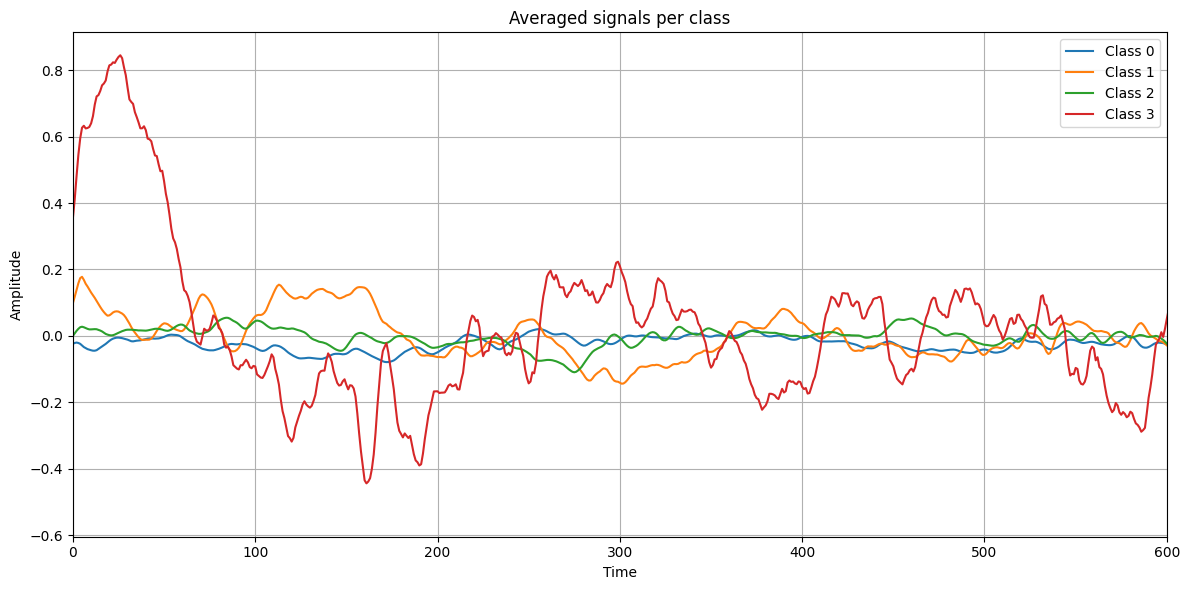

In [11]:
# plot mean distribution
max_lengths = 18286
df_norm = pd.DataFrame({"Data": normalized_data, "Class": df["Class"]})
df_norm["Data"] = df_norm["Data"].apply(lambda sample: np.pad(sample, (0, max_lengths - sample.shape[0])))
mean_signals = [np.mean(np.stack(df_norm[df_norm["Class"] == i]["Data"].to_numpy()), axis=0) for i in range(len(classes))]
plt.figure(figsize=(12, 6))

for mean_signal, clss in zip(mean_signals, classes):
    plt.plot(mean_signal, label=clss)

plt.title("Averaged signals per class")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.xlim(0, 600)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Create Training and Validation Split (80/20)

In [135]:
# create training and validation split
X_train, X_validation, y_train, y_validation = train_test_split(ecg_data, labels, test_size=0.2, random_state=0, stratify=labels)

# X_train = [np.array(x, dtype=np.float32) for x in X_train]
# X_validation = [np.array(x, dtype=np.float32) for x in X_validation]
train_lengths = [x.shape[0] for x in X_train]
validation_lengths = [x.shape[0] for x in X_validation]


# verify that the training and validation split is proportional to the original class distribution
counter0 = Counter(labels)
counter1 = Counter(y_train)
counter2 = Counter(y_validation)

total0 = len(labels)
ratios0 = np.array([counter0[0]/total0, counter0[1]/total0, counter0[2]/total0, counter0[3]/total0]) # original dataset ratios

total1 = counter1[0] + counter1[1] + counter1[2] + counter1[3]
ratios1 = np.array([counter1[0]/total1, counter1[1]/total1, counter1[2]/total1, counter1[3]/total1]) # training dataset ratios

total2 = counter2[0] + counter2[1] + counter2[2] + counter2[3]
ratios2 = np.array([counter2[0]/total2, counter2[1]/total2, counter2[2]/total2, counter2[3]/total2]) # validation dataset ratios

assert np.allclose(ratios0, ratios1, atol=1e-3)
assert np.allclose(ratios0, ratios2, atol=1e-3)
assert np.allclose(ratios1, ratios2, atol=1e-3)


# prepare data for training
# X_train, y_train = torch.tensor(zero_pad_data(X_train, max_val), dtype=torch.float32), torch.tensor(y_train)
# X_validation, y_validation = torch.tensor(zero_pad_data(X_validation, max_val), dtype=torch.float32), torch.tensor(y_validation)

# Task 1.2 - Modeling and Tuning

### Model 1 (Neural Network):

Define model architecture

In [126]:
class CNNLSTM(nn.Module):
    def __init__(
            self, 
            channels: list[int], 
            kernel_sizes: list[int], 
            hidden_size: int, 
            num_layers: int,
            output_size: int,
            bidirectional: bool,  
            n_fft: int = 256, 
            hop_length: int = 128
    ):
        super(CNNLSTM, self).__init__()
        assert len(channels) == len(kernel_sizes)

        # input --> stft --> Conv2d --> BatchNorm2d --> ReLu --> MaxPool2d
        # define CNN model (Conv2d) to extract local patterns in sequences
        self.cnn = nn.Sequential()
        for idx in range(len(channels)):
            in_channels = 1 if idx == 0 else channels[idx - 1]
            out_channels = channels[idx]
            self.cnn.add_module(
                f"conv{idx}", 
                nn.Conv2d(
                    in_channels, out_channels,
                    kernel_size=kernel_sizes[idx], stride=1, padding=0
                )
            )
            self.cnn.add_module(f"bn{idx}", nn.BatchNorm2d(channels[idx]))
            self.cnn.add_module(f"relu{idx}", nn.ReLU())
            self.cnn.add_module(f"max_pool{idx}", nn.MaxPool2d(2))

        self.n_fft = n_fft
        self.hop_length = hop_length
        self.len_num = 2 * len(channels)

        # define LSTM model to extract global patterns in sequences
        height = (n_fft // 2) + 1
        for kernel_size in kernel_sizes:
            height = math.floor(height - kernel_size) + 1 # conv-layer
            height = math.floor((height - 2) / 2) + 1 # maxpool-layer

        input_size = channels[-1] * height
        self.bidirectional = bidirectional
        self.rnn = nn.LSTM(
            input_size, 
            hidden_size, 
            num_layers=num_layers, 
            batch_first=True, 
            dropout=0.5,
            bidirectional=bidirectional
        )
        directions = 2 if bidirectional else 1
        hidden_size *= directions
        self.fc = nn.Linear(hidden_size , output_size)
        # self.fc2 = nn.Linear(hidden_size // 2, output_size)
    
    def forward(self, x: torch.Tensor, lengths: torch.Tensor):
        
        # feature extraction
        window = torch.hann_window(self.n_fft).to(x.device)
        x = torch.stft(x, n_fft=self.n_fft, hop_length=self.hop_length, window=window, return_complex=True).abs()
        
        # compute stft-lengths
        pad = self.n_fft / 2
        for idx, l in enumerate(lengths):
            temp = math.floor((l + 2 * pad - self.n_fft) / self.hop_length) + 1
            lengths[idx] = temp

        # apply cnn model
        x = x.unsqueeze(dim=1)
        x = self.cnn(x) # output-shape: [64, 64, 62, 33] (batch_size, channels, freq_bins, time_bins)
        
        # re-calculate the lengths
        # lengths = (lengths / self.hop_length).floor()
        for idx, l in enumerate(lengths):
            temp = math.floor(l - 3) + 1
            temp = math.floor(temp - 3) + 1
            lengths[idx] = temp

        # lengths = math.floor(lengths - self.len_num) + 1 # conv-layer
        # # lengths = (lengths / self.len_num).floor() # maxpool-layer
        # lengths = math.floor(lengths - self.len_num) + 1 # maxpool-layer
        
        # prepare data for rnn
        x = x.view(x.size(0), -1, x.size(3))
        x = x.permute(0, 2, 1)
        lengths = lengths.clamp(max=x.size(1))
        x = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)

        # apply lstm model
        _, (hn, cn) = self.rnn(x)
        if self.bidirectional:
            final_hn = torch.cat((hn[-2], hn[-1]), dim=1) # consider forward and backward direction
        else:
            final_hn = hn[-1]

        x = self.fc(final_hn)
        # x = self.fc2(x)
        return x


Define training and test routine

In [127]:
def train_model(
    model: nn.Module, 
    device: torch.device,
    train_loader: torch.utils.data.DataLoader,
    test_loader: torch.utils.data.DataLoader,
    train_fn: callable,
    test_fn: callable,
    criterion: nn.Module,
    lr=0.001, 
    weight_decay=0.0001,
    step_size=10, 
    gamma=0.1, 
    epochs=10,
    **additional_params
):
    train_params = additional_params.pop("train_params", {})
    test_params = additional_params.pop("test_params", {})
    
    train_losses, test_losses = [], []
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
    
    for epoch in range(1, epochs + 1):
        train_loss = train_fn(model, device, train_loader, criterion, optimizer, epoch, **train_params)
        test_loss = test_fn(model, device, test_loader, epoch, **test_params)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        scheduler.step()

    return train_losses, test_losses

In [128]:
def train(
        model: nn.Module, 
        device: torch.device, 
        train_loader: torch.utils.data.DataLoader, 
        criterion: nn.Module,
        optimizer: optim.Optimizer, 
        epoch: int
):
    model.train()
    train_loss = 0.
    for batch_idx, (data, target, lengths) in enumerate(train_loader):
        # forward pass
        data = data.to(device)
        target = target.to(device)
        lengths = lengths.to(device)
        optimizer.zero_grad()
        output = model(data, lengths)
        # backward pass
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += F.cross_entropy(output, target, reduction="sum").item()
        
        if batch_idx % 10 == 0:
            data_processed = batch_idx * len(data)
            total_data = len(train_loader.dataset)
            progress = (100. * batch_idx) / len(train_loader)
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, data_processed, total_data, progress, loss.item()
            ), end="\r")
    
    train_loss /= len(train_loader.dataset)
    return train_loss

def test(
        model: nn.Module, 
        device: torch.device, 
        validation_loader: torch.utils.data.DataLoader,
        epoch: int
):
    model.eval()
    test_loss = 0.
    correct = 0
    correct_per_class = torch.zeros(4)
    with torch.no_grad():
        for batch_idx, (data, target, lengths) in enumerate(validation_loader):
            # do forward pass
            data, target, lengths = data.to(device), target.to(device), lengths.to(device)
            output = model(data, lengths)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            # compute correct predictions
            preds = output.argmax(dim=1, keepdim=False)
            mask = preds == target
            correct_preds = torch.count_nonzero(mask).item()
            correct += correct_preds
            for t, m in zip(target, mask):
                if m: correct_per_class[t] += 1

    total_data = len(validation_loader.dataset)
    test_loss /= total_data
    progress = (100. * correct)  / len(validation_loader.dataset)
    
    print("Test Set (Epoch {}):\tAverage Loss {:.4f}\tAccuracy: {}/{} ({:.0f}%)\n".format(
        epoch, test_loss, correct, total_data, progress
    ), end="\r")

    corr0, total0 = correct_per_class[0], counter2[0]
    perc0 = (100. * corr0) / total0
    corr1, total1 = correct_per_class[1], counter2[1]
    perc1 = (100. * corr1) / total1
    corr2, total2 = correct_per_class[2], counter2[2]
    perc2 = (100. * corr2) / total2
    corr3, total3 = correct_per_class[3], counter2[3]
    perc3 = (100. * corr3) / total3
    print("Class 0: {:.0f}/{} ({:.0f}%)\tClass 1: {:.0f}/{} ({:.0f}%)\tClass 2: {:.0f}/{} ({:.0f}%)\tClass 3: {:.0f}/{} ({:.0f}%)\n".format(
        corr0, total0, perc0, corr1, total1, perc1, corr2, total2, perc2, corr3, total3, perc3
    ))
    
    return test_loss

def evaluate_model(
        model: nn.Module,
        device: torch.device,
        test_loader: torch.utils.data.DataLoader,
        y_true: torch.Tensor,
        target_names: list
):
    model.eval()
    y_pred = torch.empty(0)
    
    with torch.no_grad():
        for data, _ in test_loader:
            # forward pass
            data = data.to(device)
            output = model(data)
            # compute correct predictions
            new_pred = output.argmax(dim=1, keepdim=False)
            y_pred = torch.cat((y_pred, new_pred))
    
    classification_report(y_true, y_pred, target_names=target_names)

In [231]:
import csv

a = [0, 1, 2]
with open("test.csv", "w", newline="") as f:
    writer = csv.writer(f)
    for x in a:
        writer.writerow([x])

Train and evaluate model

In [129]:
num_samples_per_class = torch.from_numpy(df.groupby("Class").count()["Data"].to_numpy())
weights =  num_samples_per_class.sum() / (num_samples_per_class * len(num_samples_per_class))

In [130]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training of the model is running with: {device}")

# hyperparameters
batch_size = 32
lr = 0.001
weight_decay = 0.0001

# features
n_fft = 256
hop_length = 128
# cnn
channels = [32, 64]
kernel_sizes = [3, 3]
# lstm
hidden_size = 128
num_layers = 2
output_size = 4
bidirectional = False

# initialize model
model = CNNLSTM(
    channels, kernel_sizes, 
    hidden_size, num_layers, 
    output_size, bidirectional,
    n_fft=n_fft, hop_length=hop_length
).to(device)

# criterion = nn.CrossEntropyLoss(weight=weights.float().to(device))
criterion = nn.CrossEntropyLoss(weight=weights.to(device))

training_data = TimeSeriesDataset(X_train, y_train, train_lengths)
validation_data = TimeSeriesDataset(X_validation, y_validation, validation_lengths)
train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
validation_loader = DataLoader(validation_data, batch_size=batch_size, collate_fn=collate_fn)

# training and test loop
train_losses, test_losses = train_model(
    model,
    device,
    train_loader,
    validation_loader,
    train,
    test,
    criterion
)

# evaluate_model(model, device, validation_loader, y_validation, classes)

Training of the model is running with: cpu


KeyboardInterrupt: 

In [222]:
import os
import neurokit2 as nk
feature_dir = "features/"
os.makedirs(feature_dir, exist_ok=True)

for i, seq in enumerate(X_train):
    #signal, info = nk.ecg_process(seq, sampling_rate=300)
    vec = nk.ecg_clean(seq, sampling_rate=300)
    np.save(f"{feature_dir}{i}.npy", vec)
    print(i, end="\r")

### Model 2 (Random Forest):
Define pipeline:
- Feature extraction using stft
- define model and train model
- evaluate model

In [17]:
### ---------------------------------------- ###
### 1. Process raw data and extract features ###
### ---------------------------------------- ###

def extract_features(
    X: list[np.array],
    interp_len = 9000,
    interp_mode="linear",
    n_fft=1024,
    hop_length=128
):
    features = []
    for x in X:
        signal = torch.tensor(
            x, dtype=torch.float32
        ).unsqueeze(0).unsqueeze(0)
        signal = F.interpolate(
            signal,
            size=interp_len,
            mode=interp_mode
        )
        signal = signal.squeeze()
        hann_window = torch.hann_window(n_fft)
        spectrogram = torch.stft(
            signal, 
            n_fft=n_fft, 
            hop_length=hop_length, 
            window=hann_window,
            return_complex=True
        )
        amplitude = spectrogram.abs()
        # energy = amplitude ** 2
        mean_amp = amplitude.mean(dim=1)
        features.append(mean_amp.numpy())
    
    return np.array(features)

X_train_features = extract_features(X_train)

### ------------------------- ###
### 2. Define and train model ###
### ------------------------- ###

class_weights = {
    0: weights[0], 
    1: weights[1], 
    2: weights[2], 
    3: weights[3]
}
rf = RandomForestClassifier(
    n_estimators=120,
    max_depth=12,
    random_state=42,
    class_weight=class_weights
)
rf.fit(X_train_features, y_train)


### -------------------------- ###
### 3. Test and evaluate model ###
### -------------------------- ###

X_test_features = extract_features(X_validation)
y_pred = rf.predict(X_test_features)
print(classification_report(y_validation, y_pred))

# c1 = Counter(y_validation)
# print(sorted(c1.items(), key=lambda item: item[0]))
# c2 = Counter(y_pred)
# print(sorted(c2.items(), key=lambda item: item[0]))

              precision    recall  f1-score   support

           0       0.67      0.90      0.77       728
           1       0.56      0.29      0.38       110
           2       0.54      0.27      0.36       353
           3       0.56      0.42      0.48        45

    accuracy                           0.65      1236
   macro avg       0.58      0.47      0.50      1236
weighted avg       0.62      0.65      0.61      1236



# Tests

In [14]:
from scipy.signal import resample

def resample_signal(signal, target_length, _type="array"):
    
    result = signal
    if len(signal) > target_length:
        result = signal[:target_length]

    elif len(signal) < target_length:
        result = resample(signal, target_length)
    
    if _type == "array":
        result = result.astype(np.float32)
    else:
        result = torch.tensor(result, dtype=torch.float32)
    
    return result

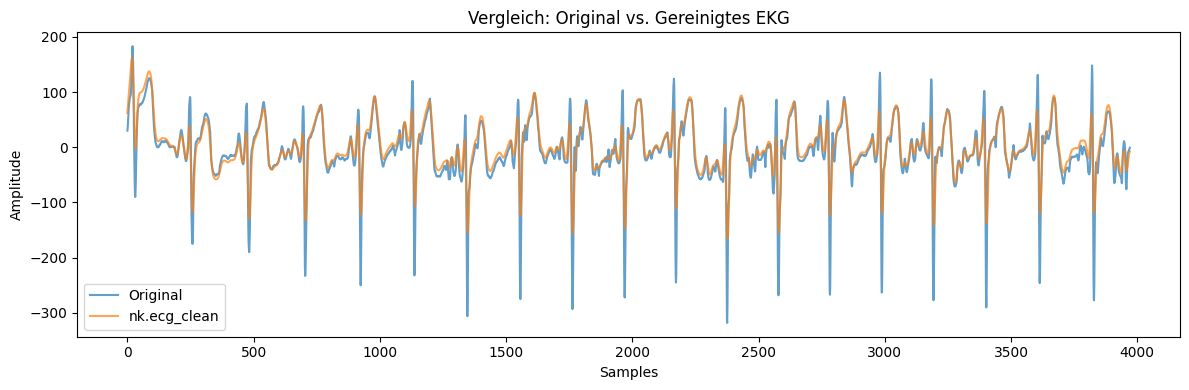

In [56]:
import neurokit2 as nk
import numpy as np
import matplotlib.pyplot as plt

# 1. Simuliere ein EKG-Signal (oder lade dein eigenes)
signal = X_train[10]

# 2. Bereinige das Signal mit nk.ecg_clean
cleaned = nk.ecg_clean(signal, sampling_rate=500)

# 3. Plot: Original vs. Bereinigt
plt.figure(figsize=(12, 4))
plt.plot(signal, label="Original", alpha=0.7)
plt.plot(cleaned, label="nk.ecg_clean", alpha=0.7)
plt.title("Vergleich: Original vs. Gereinigtes EKG")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.legend()
plt.tight_layout()
plt.show()

In [57]:
signal = X_train[0]
0.05 * np.std(signal) 

9.893647504894801

In [142]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import neurokit2 as nk

### ---------------------------------------- ###
### 1. Process raw data and extract features ###
### ---------------------------------------- ###

def extract_features(
    X: list[np.array],
    y: list[int],
    interp_len = 9000,
    n_fft=1024,
    hop_length=128,
    augment=True
):
    features = []
    upd_labels = []
    for x, label in zip(X, y):

        signal = x.copy()
        window = torch.hann_window(n_fft)
        # signal = nk.ecg_clean(x.copy(), sampling_rate=300)
        if augment and label in [3]: # keine Änderung für andere Klassen
            # Amplitude Scaling
            if label == 0:
                scale = np.random.uniform(0.5, 1.5)  # stärkere Skalierung
                jitter_std = 0.2 * np.std(signal)   # stärkeres Jitter
            else:
                scale = np.random.uniform(0.9, 1.1)  # mildes Scaling
                jitter_std = 0.02 * np.std(signal)   # schwaches Jitter

            # Jittering (additives Rauschen)
            jitter = np.random.normal(0, jitter_std, size=signal.shape)
            augmented_signal = (signal + jitter) * scale
            augmented_signal = resample_signal(augmented_signal, interp_len, "tensor")

            spectrogram = torch.stft(augmented_signal, n_fft=n_fft, hop_length=hop_length, window=window,return_complex=True)
            mean = spectrogram.abs().mean(dim=1)

            features.append(mean)
            upd_labels.append(label)
        
        resampled = resample_signal(signal.copy(), interp_len, "tensor")

        spectrogram = torch.stft(resampled, n_fft=n_fft, hop_length=hop_length, window=window,return_complex=True)
        mean = spectrogram.abs().mean(dim=1)

        features.append(mean)
        upd_labels.append(label)
    
    return np.array(features), upd_labels

import numpy as np
import torch
import neurokit2 as nk
from collections import defaultdict

def extract_features_test(
    X: list[np.array],
    y: list[int],
    interp_len = 9000,
    n_fft=1024,
    hop_length=128,
    augment=True
):
    features = []
    upd_labels = []
    for x, label in zip(X, y):

        apply_aug = False
        signal = x.copy()
        if augment and label in [0, 2]:
            # 50% Wahrscheinlichkeit, das Sample zu augmentieren
            apply_aug = np.random.rand() < 0.5

        if apply_aug and label == 2:
            signal = nk.ecg_clean(signal, sampling_rate=300)

            # if label == 0:
            #     scale = np.random.uniform(0.95, 1.05)
            #     jitter_std = 0.02 * np.std(signal)
            # else:
            #     scale = np.random.uniform(0.97, 1.03)
            #     jitter_std = 0.01 * np.std(signal)
            
            # jitter = np.random.normal(0, jitter_std, size=signal.shape)
            # signal = (signal + jitter) * scale

        resampled = resample_signal(signal.copy(), interp_len, "tensor")
        window = torch.hann_window(n_fft)

        spectrogram = torch.stft(resampled, n_fft=n_fft, hop_length=hop_length,
                                 window=window, return_complex=True)
        spec_abs = spectrogram.abs()
        mean = spec_abs.mean(dim=1)
        std = spec_abs.std(dim=1)
        feature = torch.cat((mean, std), dim=0)

        features.append(feature.numpy())
        upd_labels.append(label)
    
    return features, upd_labels

import numpy as np
import torch
from scipy.signal import resample
from scipy.ndimage import shift
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# --- 1) Augmentierungs- und Feature-Extraction-Funktionen ---

def augment_signal(signal: np.ndarray, label: int) -> np.ndarray:
    """Klassenabhängige Augmentierung für EKG-Signale."""
    # Jitter
    sigma = 0.05 if label == 0 else 0.03 if label == 2 else 0.02
    signal = signal + np.random.normal(0, sigma, size=signal.shape)
    # Amplitude scaling
    low, high = (0.8, 1.2) if label == 0 else (0.9, 1.1) if label == 2 else (0.95, 1.05)
    signal = signal * np.random.uniform(low, high)
    # Time warp
    if np.random.rand() < (0.5 if label in (0,2) else 0.3):
        orig_len = len(signal)
        factor = np.random.normal(1.0, 0.1)
        new_len = max(int(orig_len * factor), 1)
        warped = np.interp(np.linspace(0, orig_len, new_len),
                           np.arange(orig_len), signal)
        signal = np.interp(np.arange(orig_len), np.linspace(0, orig_len, new_len), warped)
    # Temporal shift
    shift_val = np.random.randint(-20, 21)
    signal = shift(signal, shift_val, cval=0)
    # Frequency masking
    fft = np.fft.rfft(signal)
    mask_width = np.random.randint(1, 5)
    start = np.random.randint(0, len(fft) - mask_width)
    fft[start:start + mask_width] = 0
    signal = np.fft.irfft(fft, n=len(signal))
    return signal

def extract_features_new(X: list[np.ndarray], y: list[int], _set="train",
                     interp_len=9000, n_fft=1024, hop_length=128):
    """
    Resample/Crop → Augment (wenn train & Klasse 0/2) → STFT → Log-Spectrogramm → mean per freq.
    """
    feats, labels = [], []
    for x, label in zip(X, y):
        # normalize
        sig = (x - x.mean()) / (x.std() + 1e-6)
        sig = resample_signal(sig, interp_len)
        # augment
        if _set == "train" and label in [0]:
            sig = augment_signal(sig, label)
        # STFT + log spectrogram
        tensor = torch.tensor(sig, dtype=torch.float32).unsqueeze(0)
        stft = torch.stft(tensor, n_fft=n_fft, hop_length=hop_length,
                          win_length=n_fft, return_complex=True).squeeze(0)
        spec = stft.abs()
        feature = spec.mean(dim=1).numpy()
        feats.append(feature)
        labels.append(label)
    return np.stack(feats), np.array(labels)


# --- 1. Augmentation Klasse 2 ---
X_train_features, y_train_aug = extract_features_new(X_train, y_train, _set="train")


### ------------------------- ###
### 2. Define and train model ###
### ------------------------- ###

# --- 3. SMOTE zum Ausbalancieren ---
# smote = SMOTE(sampling_strategy={1: 1000, 2: 1500, 3: 1000}, random_state=42)
# X_bal, y_bal = smote.fit_resample(X_train_features, y_train_aug)

# Nur Klasse 0 & 2
# y_train = np.array(y_train)
# y_train_aug = np.array(y_train_aug)
# mask = (y_train_aug == 0) | (y_train_aug == 2)
# X_02 = X_train_features[mask]
# y_02 = y_train_aug[mask]  # oder y_bin = (y_02 == 2).astype(int)

# # X: z.B. aus STFT oder Wavelet
# # y: Klassenlabels (0–3)
# plot_feature_projection(X_02, y_02, method='tsne')
# plot_feature_projection(X_02, y_02, method='umap')

rf = RandomForestClassifier(
    n_estimators=50,
    max_depth=12,
    random_state=42,
    class_weight="balanced"
)
rf.fit(X_train_features, y_train_aug)


### -------------------------- ###
### 3. Test and evaluate model ###
### -------------------------- ###

X_test_features, y_test_aug = extract_features_new(X_validation, y_validation, _set="test")
y_pred = rf.predict(X_test_features)

# c1 = Counter(y_validation)
# print(sorted(c1.items(), key=lambda item: item[0]))
# c2 = Counter(y_pred)
# print(sorted(c2.items(), key=lambda item: item[0]))

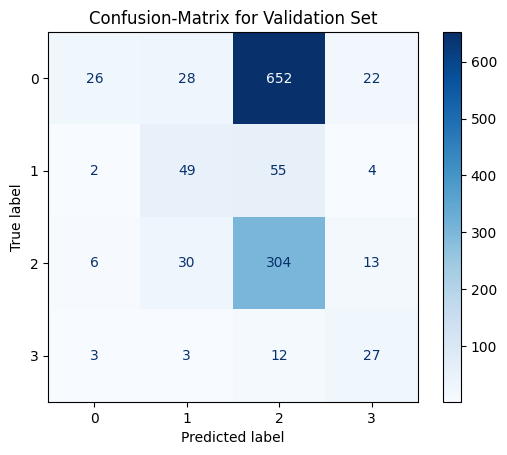

              precision    recall  f1-score      support
0              0.702703  0.035714  0.067974   728.000000
1              0.445455  0.445455  0.445455   110.000000
2              0.297165  0.861190  0.441860   353.000000
3              0.409091  0.600000  0.486486    45.000000
accuracy       0.328479  0.328479  0.328479     0.328479
macro avg      0.463603  0.485590  0.360444  1236.000000
weighted avg   0.553298  0.328479  0.223587  1236.000000


In [143]:
all_classes = ["Normal", "AF", "Other", "Noisy"]
conf_mat = confusion_matrix(y_test_aug, y_pred)
disp = ConfusionMatrixDisplay(conf_mat, display_labels=rf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion-Matrix for Validation Set")
plt.show()

res_df = pd.DataFrame(classification_report(y_test_aug, y_pred, output_dict=True)).transpose()
print(res_df)

In [145]:
import numpy as np
import torch
from scipy.signal import resample
from scipy.ndimage import shift
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# --- 1) Augmentierungs- und Feature-Extraction-Funktionen ---

def augment_signal(signal: np.ndarray, label: int) -> np.ndarray:
    """Klassenabhängige Augmentierung für EKG-Signale."""
    # Jitter
    sigma = 0.05 if label == 0 else 0.03 if label == 2 else 0.02
    signal = signal + np.random.normal(0, sigma, size=signal.shape)
    # Amplitude scaling
    low, high = (0.8, 1.2) if label == 0 else (0.9, 1.1) if label == 2 else (0.95, 1.05)
    signal = signal * np.random.uniform(low, high)
    # Time warp
    if np.random.rand() < (0.5 if label in (0,2) else 0.3):
        orig_len = len(signal)
        factor = np.random.normal(1.0, 0.1)
        new_len = max(int(orig_len * factor), 1)
        warped = np.interp(np.linspace(0, orig_len, new_len),
                           np.arange(orig_len), signal)
        signal = np.interp(np.arange(orig_len), np.linspace(0, orig_len, new_len), warped)
    # Temporal shift
    shift_val = np.random.randint(-20, 21)
    signal = shift(signal, shift_val, cval=0)
    # Frequency masking
    fft = np.fft.rfft(signal)
    mask_width = np.random.randint(1, 5)
    start = np.random.randint(0, len(fft) - mask_width)
    fft[start:start + mask_width] = 0
    signal = np.fft.irfft(fft, n=len(signal))
    return signal

def extract_features(X: list[np.ndarray], y: list[int], _set="train",
                     interp_len=9000, n_fft=1024, hop_length=128):
    """
    Resample/Crop → Augment (wenn train & Klasse 0/2) → STFT → Log-Spectrogramm → mean per freq.
    """
    feats, labels = [], []
    for x, label in zip(X, y):
        # normalize
        sig = (x - x.mean()) / (x.std() + 1e-6)
        # fixed length
        if len(sig) < interp_len:
            sig = resample(sig, interp_len)
        elif len(sig) > interp_len:
            start = np.random.randint(0, len(sig) - interp_len + 1)
            sig = sig[start:start + interp_len]
        # augment
        if _set == "train" and label in (0, 2):
            sig = augment_signal(sig, label)
        # STFT + log spectrogram
        tensor = torch.tensor(sig, dtype=torch.float32).unsqueeze(0)
        stft = torch.stft(tensor, n_fft=n_fft, hop_length=hop_length,
                          win_length=n_fft, return_complex=True).squeeze(0)
        spec = torch.abs(stft)
        feature = torch.log1p(spec).mean(dim=1).numpy()
        feats.append(feature)
        labels.append(label)
    return np.stack(feats), np.array(labels)

# --- 2) Daten vorbereiten und splitten ---

# X_raw, y_raw = deine rohen Listen
X_feats, y_feats = extract_features(X_train, y_train, _set="train")

# --- 3) Random Forest Training ---

rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    random_state=42,
    class_weight="balanced"
)
rf.fit(X_feats, y_feats)

# --- 4) Evaluation ---

X_feats_h, y_feats_h = extract_features(X_validation, y_validation, _set="test")

y_pred = rf.predict(X_feats_h)
print("Confusion Matrix:")
print(confusion_matrix(y_feats_h, y_pred))
print("\nClassification Report:")
print(classification_report(y_feats_h, y_pred, digits=4))

Confusion Matrix:
[[ 12 524 124  68]
 [  0  97   8   5]
 [  4 280  42  27]
 [  2   7   2  34]]

Classification Report:
              precision    recall  f1-score   support

           0     0.6667    0.0165    0.0322       728
           1     0.1068    0.8818    0.1906       110
           2     0.2386    0.1190    0.1588       353
           3     0.2537    0.7556    0.3799        45

    accuracy                         0.1497      1236
   macro avg     0.3165    0.4432    0.1904      1236
weighted avg     0.4796    0.1497    0.0951      1236



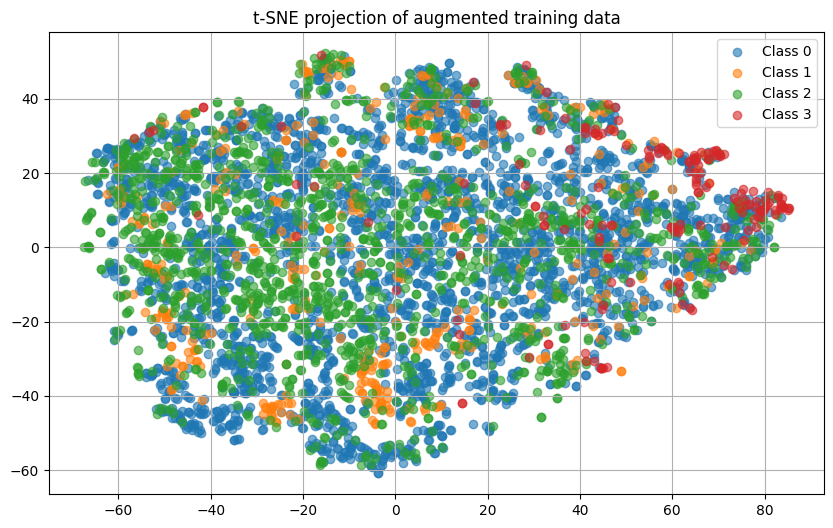

In [124]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_tsne(features, labels):
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    X_2d = tsne.fit_transform(features)

    plt.figure(figsize=(10, 6))
    for cls in np.unique(labels):
        idx = np.where(np.array(labels) == cls)
        plt.scatter(X_2d[idx, 0], X_2d[idx, 1], label=f"Class {cls}", alpha=0.6)
    plt.legend()
    plt.title("t-SNE projection of augmented training data")
    plt.grid(True)
    plt.show()

plot_tsne(np.array(X_train_features), y_train_aug)

In [114]:
Counter(y_train_aug)

Counter({0: 5820, 2: 2824, 1: 878, 3: 364})

In [61]:
import numpy as np
import neurokit2 as nk

def extract_advanced_features(X, sampling_rate=300):
    features = []
    for x in X:
        print(i, end="\r")
        corrected, is_inverted = nk.ecg_invert(x, sampling_rate=sampling_rate)
        x = corrected if is_inverted else x
        cleaned = nk.ecg_clean(x, sampling_rate=sampling_rate)
        rpeaks, _ = nk.ecg_peaks(cleaned, sampling_rate=sampling_rate)
        peaks = rpeaks.get('ECG_R_Peaks', [])
        peak_mean = np.mean(peaks) if len(peaks) > 0 else 0
        try:
            hrv = nk.hrv_time(rpeaks, sampling_rate=sampling_rate, show=False)
            rmssd = hrv.get('RMSSD', 0)
            sdnn = hrv.get('SDNN', 0)
        except:
            rmssd = 0
            sdnn = 0

        feat = [
            np.mean(cleaned),
            np.std(cleaned),
            np.min(cleaned),
            np.max(cleaned),
            peak_mean,
            rmssd,
            sdnn,
        ]
        features.append(feat)
    return np.array(features)

## Class 0: 3638	Class 1: 549	Class 2: 1765	Class 3: 227

In [41]:
import numpy as np
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import neurokit2 as nk
from imblearn.over_sampling import SMOTE

# -----------------------
# 1. Resample-Funktion
# -----------------------
def resample_signal(signal, target_length):
    from scipy.signal import resample
    if len(signal) > target_length:
        return signal[:target_length].astype(np.float32)
    elif len(signal) < target_length:
        return resample(signal, target_length).astype(np.float32)
    return signal.astype(np.float32)

# -----------------------
# 2. Template für Klasse 0
# -----------------------
def create_template(X, y, target_class=0, interp_len=9000):
    class_signals = [x for x, label in zip(X, y) if label == target_class]
    resampled = [resample_signal(x, interp_len) for x in class_signals]
    return np.mean(resampled, axis=0)

# -----------------------
# 3. Abstand zum Template
# -----------------------
def distance_to_template(x, template, interp_len=9000):
    x_resampled = resample_signal(x, interp_len)
    return np.linalg.norm(x_resampled - template)

# -----------------------
# 4. Feature-Extraktion
# -----------------------
def extract_template_features(X, y, template, sampling_rate=300, interp_len=9000):
    features = []
    labels = []
    for x, label in zip(X, y):
        try:
            corrected, is_inverted = nk.ecg_invert(x, sampling_rate=sampling_rate)
            x_corr = corrected if is_inverted else x
            cleaned = nk.ecg_clean(x_corr, sampling_rate=sampling_rate)
            rpeaks, _ = nk.ecg_peaks(cleaned, sampling_rate=sampling_rate)
            rate = nk.ecg_rate(rpeaks, sampling_rate=sampling_rate)

            rr_intervals = np.diff(rpeaks["ECG_R_Peaks"]) / sampling_rate
            rr_mean = np.mean(rr_intervals) if len(rr_intervals) > 0 else 0
            rr_std = np.std(rr_intervals) if len(rr_intervals) > 0 else 0
            hr_mean = np.mean(rate) if len(rate) > 0 else 0
            hr_std = np.std(rate) if len(rate) > 0 else 0
        except Exception as e:
            # Logge oder ignoriere, aber überspringe den Sample
            continue

        stats_feat = [
            np.mean(x),
            np.std(x),
            np.min(x),
            np.max(x),
            stats.skew(x),
            stats.kurtosis(x),
            rr_mean,
            rr_std,
            hr_mean,
            hr_std
        ]

        dist = distance_to_template(x, template, interp_len)
        full_feat = stats_feat + [dist]
        features.append(full_feat)
        labels.append(label)

    return np.array(features), np.array(labels)

# -----------------------
# 5. MAIN PIPELINE
# -----------------------

# Beispiel-Daten: X, y = ...
# (Liste von 1D-Numpy-Arrays, Labels als Liste/Array)

# Augmentierte Daten erzeugen
X_train_aug, y_train_aug = augment_class(X_train, y_train, target_class=2, target_count=3000)

# Template nur aus originalen Daten
template = create_template(X_train, y_train, target_class=0, interp_len=9000)

# Features extrahieren – auf augmentierten Daten!
X_train_features = extract_template_features(X_train_aug, y_train_aug, template)
X_test_features = extract_template_features(X_validation, y_validation, template)

# PCA
pca = PCA(n_components=10)
X_train_features = pca.fit_transform(X_train_features)
X_test_features = pca.transform(X_test_features)

# SMOTE – auf augmentierten Labels
smote = SMOTE(sampling_strategy={1: 1000, 2: 1000, 3: 1000}, random_state=42)
X_train_features, y_train_balanced = smote.fit_resample(X_train_features, y_train_aug)

# Klassifikator
clf = RandomForestClassifier(n_estimators=100, max_depth=12, random_state=42, class_weight="balanced_subsample")
clf.fit(X_train_features, y_train)
y_pred = clf.predict(X_test_features)

# Ergebnis
conf_mat = confusion_matrix(y_validation, y_pred)
disp = ConfusionMatrixDisplay(conf_mat)
disp.plot(cmap='Blues')
plt.title("Confusion-Matrix")
plt.show()
print(f"Accuracy: {accuracy_score(y_validation, y_pred)}")
print(classification_report(y_validation, y_pred))

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 6531) + inhomogeneous part.

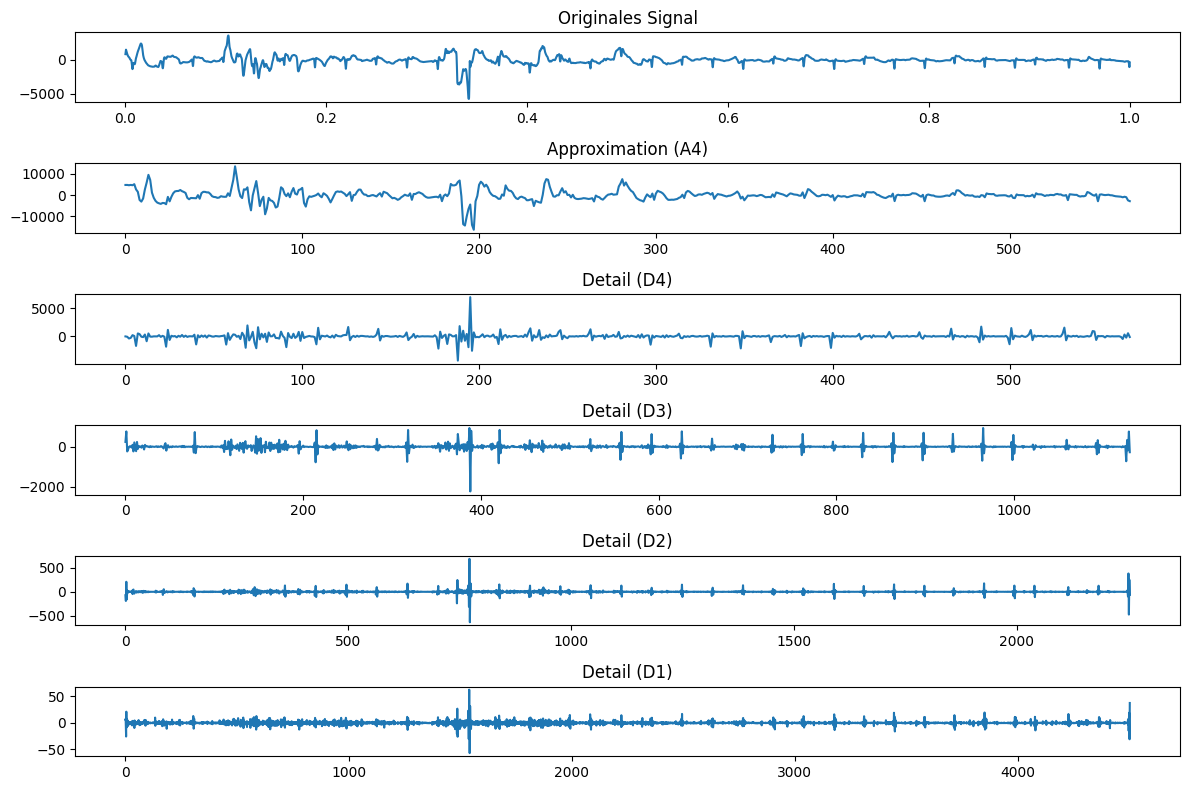

In [279]:
import numpy as np
import matplotlib.pyplot as plt
import pywt

# Beispielsignal: Sinus mit Rauschen
t = np.linspace(0, 1, 9000)
signal = X_train[4]

# Wavelet-Zerlegung
wavelet = 'db4'
level = 4
coeffs = pywt.wavedec(signal, wavelet, level=level)

# Plot: Originalsignal
plt.figure(figsize=(12, 8))
plt.subplot(level + 2, 1, 1)
plt.plot(t, signal)
plt.title("Originales Signal")

# Plot: Approximations- und Detailkoeffizienten
labels = [f"Approximation (A{level})"] + [f"Detail (D{l})" for l in range(level, 0, -1)]

for i, coeff in enumerate(coeffs):
    plt.subplot(level + 2, 1, i + 2)
    plt.plot(coeff)
    plt.title(labels[i])

plt.tight_layout()
plt.show()

In [170]:

X_1, X_2, y_1, y_2 = train_test_split(ecg_data, labels, test_size=0.5, stratify=labels)

def compute_stats(X):

    dataframe = pd.DataFrame({"Data": X})
    group = dataframe["Data"]
    all_stats = np.zeros(8)
    for series in group:
        stats = pd.Series(series).describe()
        all_stats += stats

    all_stats /= group.shape[0]
    return all_stats

a = compute_stats(X_1)
b = compute_stats(X_2)

In [171]:
a, b

(count    9795.379087
 mean        7.268990
 std       210.228848
 min     -1084.102298
 25%       -72.348737
 50%        -9.293137
 75%        66.860149
 max      1286.931693
 dtype: float64,
 count    9725.002913
 mean        7.570440
 std       214.174633
 min     -1102.826537
 25%       -73.443851
 50%        -8.923948
 75%        68.340291
 max      1312.229450
 dtype: float64)

In [ ]:
from sklearn.decomposition import PCA

print(concat.shape)
pca = PCA(n_components=20)
pca.fit(concat)

(60308185, 1)


ValueError: n_components=60308185 must be between 0 and min(n_samples, n_features)=1 with svd_solver='covariance_eigh'

In [193]:
arrays

array([array([-217, -246, -294, ...,  -14,  -11,   -9]),
       array([-446, -541, -637, ...,    7,    6,    5]),
       array([-440, -527, -614, ...,  208,  162,  119]), ...,
       array([-339, -412, -490, ...,  -42,  -36,  -29]),
       array([271, 469, 690, ..., -16, -16, -17]),
       array([-114, -140, -157, ...,  -41,  -32,  -19])], dtype=object)